In [119]:
import pandas as pd

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
df = pd.read_excel('drive/My Drive/raw_data.xlsx')

In [122]:
df.head()

,Date,Narration,Type,Category,Withdrawal,Deposit,Key word,New Category,Parties involved
0,2018-02-11 00:00:00,PHDF6854141275/BILLDKRATNAKARBANKLI,DEBIT,Uncategorized,9296.97,0.0,"phdf, billdk",Payment > Credit Card,BILLDKRATNAKARBANKLI
1,2018-05-11 00:00:00,CAPITAL FIRST 142060531-64511,DEBIT,Uncategorized,4666.00,0.0,NaN,Payment > Loan,capital first
2,2018-07-11 00:00:00,KITX65EEAV72PO6Q/PAYUOLAMONEYZIPCASH,DEBIT,Uncategorized,1118.00,0.0,NaN,Transfer > Debit,PAYUOLAMONEYZIPCASH
3,2018-09-11 00:00:00,XMM7PK63-20181109055736491,CREDIT,Uncategorized,0.00,10794.0,NaN,Transfer > Credit,NaN
4,2018-10-11 00:00:00,107468072143/CCAAIRTELINMONEY,DEBIT,Uncategorized,712.00,0.0,cca,Transfer > Debit,airtel money


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              14634 non-null  object 
 1   Narration         14583 non-null  object 
 2   Type              14634 non-null  object 
 3   Category          14634 non-null  object 
 4   Withdrawal        14634 non-null  float64
 5   Deposit           14634 non-null  float64
 6   Key word          13759 non-null  object 
 7   New Category      5714 non-null   object 
 8   Parties involved  10219 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.0+ MB


So, we have a total of 14634 samples, and more than 4000 of them don't have non-Nan labels

In [124]:
narrations = df['Narration'].apply(lambda x:str(x))

Coverting all to string, since few were of datetime format

In [125]:
import re

In [126]:
def tokenise(narration):
    narration = str(narration)
    tokens = re.split(', |_|-|!|/|\+', narration)
    if len(tokens) == 1:
        tokens = ''.join(tokens).split()
    return [token.lower() for token in tokens]

Splitting the narration string with the special characters inside the parenthesis:
(,-_!/\)
In the absence of all the mentioned characters, the string is split with simple whaitespace character.

In [127]:
tokenised_X = []
for narration in narrations:
    tokenised_X.append(tokenise(narration))

In [128]:
tokenised_X[:10]

[['phdf6854141275', 'billdkratnakarbankli'],
 ['capital first 142060531', '64511'],
 ['kitx65eeav72po6q', 'payuolamoneyzipcash'],
 ['xmm7pk63', '20181109055736491'],
 ['107468072143', 'ccaairtelinmoney'],
 ['642318036', 'techmuthootfincorpli'],
 ['phdf6893804098', 'billdkratnakarbankli'],
 ['ach d', ' bd', 'nach', 'paysense', 'txoj348504'],
 ['ach d', ' retailassetdeptofrbl', '00764994'],
 ['emi', '4592593', 'chq', 's45925930161', '11184592593']]

In [129]:
def filter_numbers(narration):
    filtered_narration = []
    for token in narration:
        if token.isdigit():
            token = f'num{narration.index(token)}'
        else:
            token = re.sub("^\d+|\d+$", "", token)
        filtered_narration.append(token)
    return filtered_narration

Since we will be encoding each token, it's important to keep the number of unique encodings required. That is why numbers at the start and end of common words are removed.

Also, most number only tokens are replaced with  a simple 'num' string formatted with the index of that token in the list. This also keeps their position information intact.

In [130]:
X_data = []
for narration in tokenised_X:
    X_data.append(filter_numbers(narration))

In [131]:
X_data[:10]

[['phdf', 'billdkratnakarbankli'],
 ['capital first ', 'num1'],
 ['kitx65eeav72po6q', 'payuolamoneyzipcash'],
 ['xmm7pk', 'num1'],
 ['num0', 'ccaairtelinmoney'],
 ['num0', 'techmuthootfincorpli'],
 ['phdf', 'billdkratnakarbankli'],
 ['ach d', ' bd', 'nach', 'paysense', 'txoj'],
 ['ach d', ' retailassetdeptofrbl', 'num2'],
 ['emi', 'num1', 'chq', 's', 'num4']]

Let's check the size distribution of narrations

In [132]:
narr_len = []
for narration in X_data:
    narr_len.append(len(narration))

In [133]:
pd.Series(narr_len).value_counts()

4     3315
5     2943
3     2625
6     2254
2     1749
7      859
8      204
9      193
1      172
10      98
11      82
13      56
12      34
15      14
14      14
18       8
21       6
22       5
26       1
20       1
23       1
dtype: int64

In [134]:
narr_len = pd.Series(narr_len)
sum(narr_len[narr_len >= 20])

305

Clearly, most narrations have token size with single digit numbers. 

In [135]:
all_tokens = []
for narration in X_data:
    for token in narration:
        all_tokens.append(token)

Let's also have a look at the most common tokens

In [136]:
len(set(all_tokens))

7608

In [137]:
pd.Series(all_tokens).value_counts()

num1                     3377
num2                     2889
num3                     2803
upi                      2640
                         2290
                         ... 
citi card pa                1
dba10301madra               1
uy5o1bgdwr                  1
rahimatnagarhyderabad       1
oid6744994753@paytm         1
Length: 7608, dtype: int64

In [138]:
from tensorflow.keras.preprocessing.text import Tokenizer

Let's map and convert the tokens to their number encodings

In [139]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [140]:
X_encoded = tokenizer.texts_to_sequences(X_data)

In [141]:
X_encoded[:10]

[[182, 348],
 [2644, 1],
 [2645, 274],
 [2646, 1],
 [22, 1787],
 [22, 2647],
 [182, 348],
 [56, 313, 258, 774, 775],
 [56, 1788, 2],
 [118, 1, 138, 81, 9]]

In [142]:
dict(list(tokenizer.word_index.items())[:20]) 

{'': 5,
 'atm': 15,
 'bangalore': 10,
 'clg': 11,
 'debit': 13,
 'hdfc': 20,
 'imps': 7,
 'j p nagar,6th p': 14,
 'neft': 18,
 'num1': 1,
 'num2': 2,
 'num3': 3,
 'num4': 9,
 'num5': 16,
 'num6': 17,
 'p2a': 12,
 'pos': 6,
 'to transfer': 19,
 'upi': 4,
 'xxxxxx': 8}

We also need to save the Tokenizer object for future use 

In [143]:
import pickle

with open('drive/My Drive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [144]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Let's pad the input data to make it structured for fitting

In [145]:
X = pad_sequences(X_encoded, padding='post')

In [146]:
X[:10]

array([[ 182,  348,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [2644,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [2645,  274,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [2646,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  22, 1787,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  22, 2647,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  

In [147]:
X.shape

(14634, 26)

Now, that we are done for the features, let's move on to the targets.

In [148]:
labels = df.iloc[:, -1].apply(lambda x:str(x))

In [149]:
len(labels.unique())

2944

In [150]:
labels.value_counts()

nan                              4415
paytm                             316
one97 communications              142
add-money                         135
add-money@paytm                   122
                                 ... 
tudivij                             1
chai garam                          1
srv retail                          1
oid7089438444@one97communicat       1
archana k                           1
Name: Parties involved, Length: 2944, dtype: int64

In [151]:
def label_encoding(label, i):
    label = str(label).lower()
    narr_index = 26
    if label != 'nan':
        for token in tokenised_X[i]:
            for j in range(len(label)):
                if label[j] in token:
                    narr_index = tokenised_X[i].index(token)   
    else:
        narr_index = 26
    return narr_index

We will use frame our problem as classification, where the targets will coresspond to the index of the tokenised feature data. We will be assuming that our tokenisation process was good enough to contain the corresponding label as one of the tokens.

If the token doesn't exist, we assume that there entity is not part of the narration, the corresponding label being 'nan', encoded as 26, since 0-25 correspond to all the possible 26 token indices in our tokenised feature set.

In [152]:
y = []
for i in range(len(labels)):
    y.append(label_encoding(labels[i], i))

In [153]:
sum(pd.Series(y)==26)

4416

A lot of labels seem to be nans.

In [154]:
import matplotlib.pyplot as plt

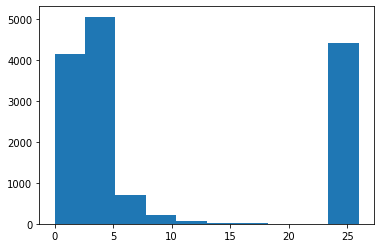

In [155]:
plt.hist(y)
plt.show()

The distribution of labels is as expected. To bring balance to our training data, we will drop a substantial portion of the nan labelled samples.

In [156]:
import numpy as np
y = pd.Series(y)
nan_indices = list(y[y==26].index)
np.random.shuffle(nan_indices)

In [157]:
y = y.drop(nan_indices[:3000])

In [158]:
y = np.array(y)

In [159]:
X = np.delete(X, nan_indices[:3000], axis=0)

In [160]:
len(y)

11634

In [161]:
len(X)

11634

In [162]:
from sklearn.model_selection import train_test_split

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Let's create a small validation set to keep an eye on the training process. Since, we already have a very few number of samples with us, we will not create a seperate post-training test set. 

In [164]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10470, 26), (1164, 26), (10470,), (1164,))

In [165]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.models import Model

In [166]:
V  = len(tokenizer.word_index)
V

7608

In [167]:
T = X_train.shape[1]
T

26

In [188]:
#Embeding dimensionality
D = 30

#Hidden state dimesnionality
M = 20

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(T+1, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 26, 30)            228270    
_________________________________________________________________
lstm_4 (LSTM)                (None, 26, 20)            4080      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                567       
Total params: 232,917
Trainable params: 232,917
Non-trainable params: 0
_________________________________________________________________


We have created an LSTM model with an embedding layer at its input to fit the data.

In [189]:
from tensorflow.keras.callbacks import ModelCheckpoint
save_at = "drive/My Drive/model.hdf5"
save_best = ModelCheckpoint(save_at, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

We will check and save the model based on the loss evaluated over the validation data after every epoch.

In [190]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [191]:
r = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, callbacks=[save_best])

Epoch 1/10
328/328 [==============================] - ETA: 0s - loss: 2.1696 - accuracy: 0.3577
Epoch 00001: val_loss improved from inf to 1.49455, saving model to drive/My Drive/model.hdf5
328/328 [==============================] - 4s 12ms/step - loss: 2.1696 - accuracy: 0.3577 - val_loss: 1.4945 - val_accuracy: 0.6151
Epoch 2/10
325/328 [============================>.] - ETA: 0s - loss: 1.2133 - accuracy: 0.6894
Epoch 00002: val_loss improved from 1.49455 to 1.07018, saving model to drive/My Drive/model.hdf5
328/328 [==============================] - 3s 9ms/step - loss: 1.2129 - accuracy: 0.6893 - val_loss: 1.0702 - val_accuracy: 0.7216
Epoch 3/10
324/328 [============================>.] - ETA: 0s - loss: 0.8503 - accuracy: 0.7757
Epoch 00003: val_loss improved from 1.07018 to 0.86931, saving model to drive/My Drive/model.hdf5
328/328 [==============================] - 3s 9ms/step - loss: 0.8500 - accuracy: 0.7757 - val_loss: 0.8693 - val_accuracy: 0.7560
Epoch 4/10
323/328 [========

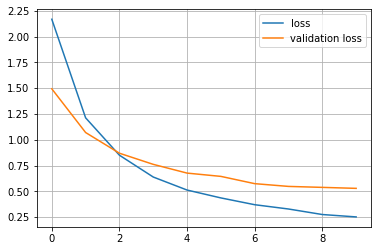

In [192]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.grid()
plt.show()

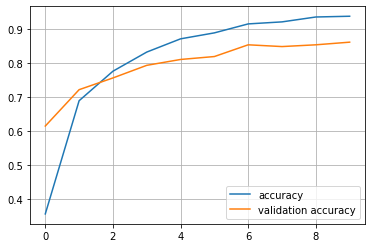

In [193]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.grid()
plt.show()

Going by the above two curves, the performance over the validation set seems to be stagnating, so we stop training any further to avoid over-fitting.

Let's do a full check over our validation set again.

In [194]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
y_hat

array([2, 2, 5, ..., 4, 1, 2])

In [195]:
y_test

array([2, 2, 5, ..., 4, 1, 2])

In [196]:
predicted_entities = []
for i in range(len(X_test)):
    narration = tokenised_X[i]
    if y_hat[i] >= len(narration):
        entity = 'nan'
    else:
        entity = narration[y_hat[i]]
    predicted_entities.append(entity)

In [197]:
predicted_entities[:20]

['nan',
 'nan',
 'nan',
 'nan',
 'ccaairtelinmoney',
 'nan',
 'nan',
 'nan',
 '00764994',
 '11184592593',
 '830717818181',
 'money@paytm',
 'money@paytm',
 'upi',
 'xxxxxxxxxx6596',
 'add',
 '35067417257',
 'payment from phonepe',
 '21680100011372',
 'payment from phonepe']